**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# A Diffusion Drift-Flux Model for Two-Phase Mixture Flow
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

**Student(s):**  Nik Kemper and Jack Kennedy<br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
  + [Weak Form of Problem Statement](#weakform)
  + [MOOSE Kernels](#kernels)
  + [Setup](#setup)
  + [Tests](#tests)
   - [Solo mixture](#solomixture)
   - [Solo vapor](#solovapor)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
 + [Tests](#tests)
   - [Fuel](#fuel)

## [Introduction](#toc)<a id="intro"></a>

Two phase flow models are notoriously difficult for the extreme number of assumptions and/or compromises required. Two phase flow problems require solving several non-linear differential equations with a myriad of different mixture velocity, bubble formation, and void fraction approximations that can be used to either simplify or correct some of the models that were made. In the model developed here, a no-slip condition is used for the mixture velocity. The vapor will also be assumed to be created using a constant source term. And an area averaged vapor fraction is used to solve for the density and the velocity of the mixture. 
The volume-average method is used for deriving a two-phase mixture balance equation for the motion of two fluid phases. The balance equation for the vapor phase is closed by a diffusion drift-flux constitutive equation. Boundary conditions for a developing fluid flow are used in cylindrical coordinates. This model is a prototype of a mixture theory for two-phase fluid flow in various equipments for example, steam generation from liquid feed water.
The program MOOSE, who was made by Idaho National Lab, will be using in this project and contains many useful tools that can be helpful in solving these equations. The first of which is that MOOSE creates what are called Kernels, that each contain an integrand that will be solved for. These integrands may contain constants, functions, or variables, and when several kernels are used, they can be used together to solve a system. 
The second is an input file that contains much of the information that MOOSE will use to solve a specified problem. The input file contains many sections, and each section requires different inputs to function. The variables section, as the name might imply, includes all the variables that are being solved for. The kernels section includes all the integrands and any other information that may be needed for any of the kernels. The BCs section is for Boundary conditions that can be programed into MOOSE and they have several boundary conditions already programmed into MOOSE such as Dirichlet, Neumann or Convective Flux boundary conditions. Finally, MOOSE also has sections for preconditioning, post-processing, and outputs that each serve to add extra functionality and flexibility to MOOSE.

## [Problem Statement](#toc)<a id="problem"></a>

Solve the convective-diffusive model problem for a two-phase, 1-D mixture flow with phase change in a pipe. Compute the mixture velocity $v:[a,b]\subset\Reals\rightarrow\Reals$ and vapor fraction $\alpha:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 \text{d}_z\bigl(\rho\,v\bigr) &= 0 \quad \forall \quad z\in [a,b] \\
 \text{d}_z\bigl(\alpha\rho_\text{v}\,v\bigr) -\text{d}_z\Bigl(\alpha\,w_\ell\,\rho\,D\,\text{d}_z w_\text{v}\Bigr) - S_\text{v} & = 0 \quad \forall \quad z\in [a,b] \\
 v(a) &= v_0 \\
 \alpha(a) &= 0, \\
 -\rho\,D \,\text{d}_z w_\text{v}(b) &= 0,
\end{align*}
where $v$ is the velocity of the mixture, $\alpha$ is the vapor fraction, $w_\text{v} = \frac{\rho_\text{v}}{\alpha\rho_\text{v} + (1-\alpha)\rho_\ell}$ is the mass density ratio of the vapor (a similar definition is used for the liquid, $w_\ell$), $\rho_\ell$ is the mass density of the liquid, $\rho_\text{v}$ is the mass density of the vapor, and $-\rho\,D \,\text{d}_z w_\text{v}$ is a diffusion constitutive model of the drift-flux of the vapor, that is: $\rho_\text{v}\,v_\text{d}$, ($v_\text{d}$ is the drift velocity). The vapor source term, $S_\text{v}$ accounts for the mass transfered from the liquid phase into the vapor phase due to vaporization phase change. The inflow port of the pipe is located at $z=a$ where the vapor fraction and mixture velocity are known. The outflow port of the pipe is located at $z=b$ where the diffusive drift flux is zero.

The equations conserve the total mass of the two phase flow system in the $[a,b]$ domain. The model is non-linear in the unknown variables.

In [ ]:
'''Domain'''

def show_domain(screenshot=False):
    import scipy.constants as unit
    unit.meter = 0.10
    unit.mm = unit.milli*unit.meter
    
    pipe_length = 1*unit.meter
    pipe_id = 3/4*unit.inch
    pipe_wall = 20*unit.mm
    pipe_od = pipe_id + 2*pipe_wall
    
    import pyvista as pv
    pv.set_plot_theme('paraview')
     
    radius_i = pipe_id/2
    radius_o = pipe_od/2
    fluid = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length, radius=radius_i)
    tmp1 = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length, radius=radius_o)
    tmp1 = tmp1.triangulate()
    tmp2 = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length*1.1, radius=radius_i)
    tmp2 = tmp2.triangulate()
    tmp2.flip_normals()
    pipe = tmp1.boolean_cut(tmp2)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 

    plo.subplot(0,0)
    plo.add_mesh(fluid, color='orange', opacity=1,)
    plo.add_mesh(pipe, color='black', opacity=.99)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Z')
    
    #plo.set_viewup([1,0,0])
    cpos = plo.show(window_size=[800, 600])
    if screenshot:
        plo.screenshot('readme-domain.png')

In [ ]:
show_domain(screenshot=False)

- Text... 

- Text... 

## [Objectives](#toc)<a id="obj"></a>

The objective of this project is to model two phase flow using a Finite Element Model (FEM) using a program that was made by Idaho National Lab called MOOSE. The two-phase flow model will be made assuming a one-dimensional differential equation that uses a diffusion term, a source term, and a convective term. A Mixture-Balance and Artificial-Velocity kernel were also added to help the non-linear ODE to converge. 

## [Approach](#toc)<a id="app"></a>

To solve the two phase flow problem, the strong form of the equations being solved needs to be converted to a weak form that can be implemented into MOOSE.       

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#problem) is as follows. Find $v \in H^1\!\bigl([a,b]\bigr)$ and $\alpha \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b \bigl(\Delta\rho\,\alpha'\,v + \rho\, v'\bigr)\, \theta\, dz &= 0 \quad \forall \quad \theta \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
    \int\limits_a^b \rho_\text{v}\,(\alpha'\,v + \alpha\,v')\,\theta\,dz 
  - \int\limits_a^b \alpha\,w_\ell\,w_\text{v}\,\Delta\rho\,D\,\alpha' \theta'\,dz 
  - \int\limits_a^b S_\text{v}\,\theta\,dz &= 0 
  \quad \forall \quad \theta \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces.
 
The finite element implementation of this weak form is carried out within the multiphysics object oriented simulation environment, MOOSE, framework.

### [MOOSE Kernels and Functions](#toc)<a id="kernels"></a>

Five kernels are used to solve for both the mixture velocity and the void coefficient in the two phase flow problem. The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. Mixture mass balance term: $\bigl(\Delta\rho\,\alpha'\,v + \rho\, v', \theta\bigr)$ 
 + [interface](./include/kernels/MixtureMassBalDivergence.h) and [implementation](./src/kernels/MixtureMassBalDivergence.C).

1. Vapor convection term: $\bigl(\rho_\text{v}\,(\alpha'\,v + \alpha\,v'),\theta\bigr)$ 
 + [interface](./include/kernels/VaporConvection.h) and [implementation](./src/kernels/VaporConvection.C).
 
1. Vapor drift-flux diffusion term: $-\bigl(\alpha\,w_\ell\,w_\text{v}\,\Delta\rho\,D\,\alpha', \theta'\bigr)$ 
 + [interface](./include/kernels/VaporDriftFluxDiffusion.h) and [implementation](./src/kernels/VaporDriftFluxDiffusion.C).
 
1. Mixture artificial-velocity term: $-\bigl(\mu\,v',\theta'\bigr)$ 
 + [interface](./include/kernels/ArtificialViscosity.h) and [implementation](./src/kernels/ArtificialViscosity.C).
 
1.  . Vapor source term: $-\bigl(S,\theta\bigr)$ 
 + [interface](./include/kernels/VaporMassTransferSource.h) and [implementation](./src/kernels/VaporMassTransferSource.C).


The function below was used to give more functionality to setting the initial guesses.
1. Initial guess for Newton's method: $q = c\,z + b$ 
 + [interface](./include/ig/InitialGuess.h) and [implementation](./src/ig/InitialGuess.C).

Where,
The constants:

$\rho_\text{l}\,$and $\rho_\text{v}\,$are the liquid and vapor densities respectively,
D is the diffusion coefficient,
$\mu\,$is a constant viscosity for the mixture
C is the slope of the initial guess variable
B is the bias or y-int of the initial guess

The functions and variables,

$\alpha\,$is the void coefficient.
V is the mixture velocity
$\theta\,$is the test function
$\rho_\,$is the mixture density
$w_\text{l}\,$and $w_\text{v}\,$are the mass density ratio of the liquid and vapor phase respectively.




### [Setup](#toc)<a id="setup"></a>

These are the initial conditions and parameters used to solve the problem.

In [34]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [35]:
'''Parameters'''

rho_l = 1000
rho_v = 1

In [36]:
'''Data (boundary conditions)'''

alpha_a = 0
v_a = 1

In [37]:
'''Plot function for FEM Solution'''
import matplotlib.pyplot as plt
def plot_solution(df, 
                  title='No Title', 
                  u1_legend='no u1 legend',
                  u2_legend='no u2 legend',
                  u1_flux_legend='no u1 flux legend',
                  u2_flux_legend='no u2 flux legend',
                  save_plot=False):
    
    
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(15, 6))

    ax1.plot(df['x'], df['mixtureVelocity'],'r*-',label=u1_legend)
    
    ax1.set_xlabel(r'$x$ [m]', fontsize=18)
    ax1.set_ylabel(r'$u_{1,h}(x)$', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True, axis='x')

    # create a twin x axis to be shared
    ax2 = ax1.twinx()

    ax2.plot(df['x'], df['vaporFraction'],'*-', color='yellow', label=u2_legend)
        
    ax2.set_ylabel(r"$u_{2,h}(x)$", fontsize=16, color='yellow')
    ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
    ax2.legend(loc='center right', fontsize=12)
    #ax2.set_ylim(0,2)
    ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_plot:
        plt.savefig('readme-result.png')
    plt.show()
    print('')

## <span style="color:red"><b>**Pending:** parameters should deliver 100% vapor quality at end of pipe</b></span>

In [38]:
'''Input file'''
!cat input.hit


# Engy-5310 Project: Steamer
# UMass Lowell Nuclear Chemical Engineering
# Nikolaus R. Kemper and Jack J. F. Kennedy
# Sat May  1 12:18:50 PM EST 2021
#

# Parameters
xmin = 0.00000e+00  # [m]
xmax = 2.50000e+01  # [m]
diff_coeff = 2.00000e-9 # [m-2/s]
artificial_viscosity = 1e-7 # [unit] Artificial term to "smooth" boundary layer effects
source_s = .2 # [kg/s] Rate of mass transfer to vapor phase i.e rate of vaporization
rho_l = 1000.0000 # [kg/m^3]
rho_v = 1.00000   # [kg/m^3]
mixture_velocity_left = 0.1 # [m/s] Initial value
vapor_fraction_left = 0  # Initial value
pts = 101

exit_V = 1e-2

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 100
    #elem_type = edge3
  []
[]

[Variables]
  [mixtureVelocity]
    order = first
    family = lagrange
    #initial_condition = ${fparse mixture_velocity_left}
    [InitialCondition]
      type = InitialGuess
      bias = ${replace mixture_velocity_left}
      coefficie

In [39]:
!./steamer-opt -i input.hit



Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun May  9 16:16:39 2021
Executable Timestamp:    Sun May  9 15:44:19 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 101
    Local:                 101
  Elems:                   
    Total:                 100
    Local:                 100
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                202
  Num Local DOFs:          202
  Variables:               { "mixtureVelocity" "vaporFraction" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:          

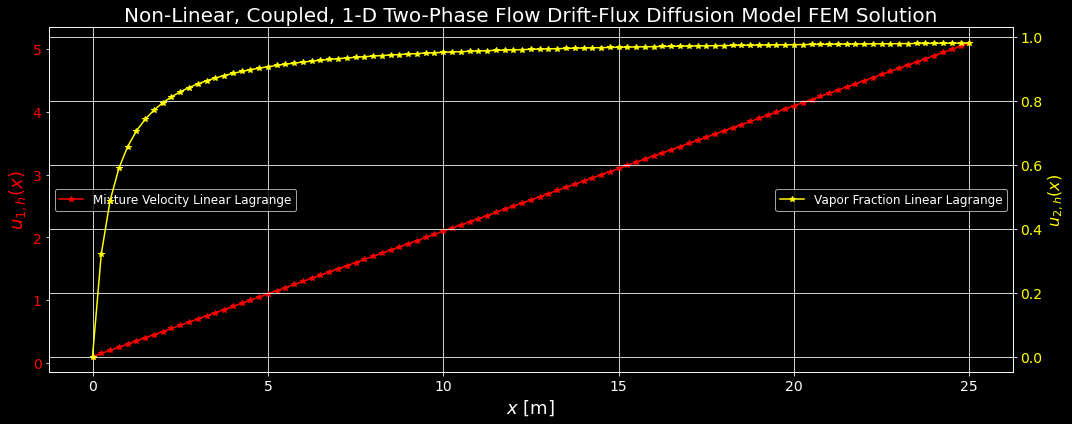

In [27]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Non-Linear, Coupled, 1-D Two-Phase Flow Drift-Flux Diffusion Model FEM Solution', 
              u1_legend=r'Mixture Velocity Linear Lagrange', u2_legend=r'Vapor Fraction Linear Lagrange', save_plot=False)

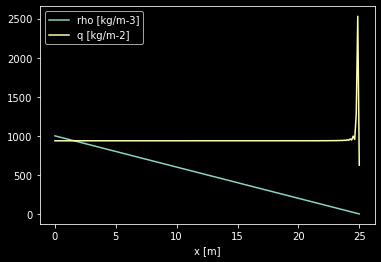

In [56]:
df
x = df['id']
v = df['mixtureVelocity']
alpha = df['vaporFraction']
rho = rho_v * alpha + (1-alpha)*rho_l
df['x [m]'] = x
df['rho [kg/m-3]'] = rho
df['q [kg/m-2]'] = rho * v
df.plot(kind='line',x='x [m]',y=['rho [kg/m-3]', 'q [kg/m-2]'])

plt.show()

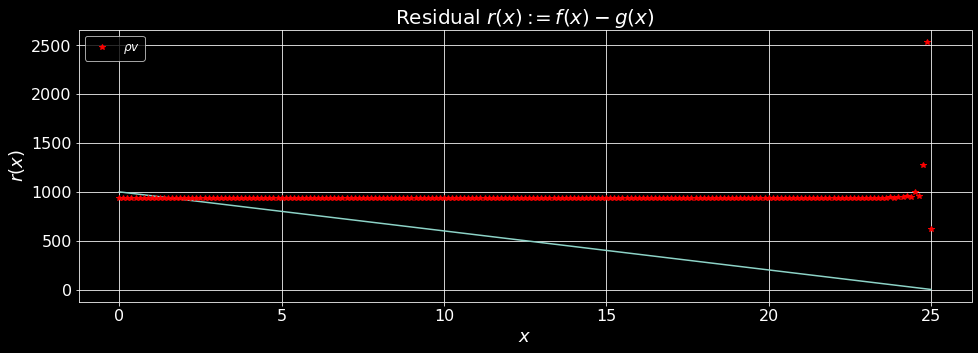

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

plt.figure(1, figsize=(16, 5))
plt.plot(df['x [m]'], rho_v * alpha + (1-alpha)*rho_l)
plt.plot(df['x [m]'], rho * v, 'r*',label=r'$\rho v$')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Tests](#toc)<a id="tests"></a>

To get each kernel to converge, each kernel was isolated, and the variables were fixed and solved for as knowns, then the variables were relaxed to auxvariables, and finally returned to normal variables to test their individual converge.

For example, with the mixture mass balance kernel (MMB), the vapor fraction was first fixed to be a linear relation between zero at the entrance and 1 at the exit. Using this, the vapor velocity could be modelled and adjusted until a reasonable model was developed. One interesting model output that as discovered was an oscillation of the vapor velocity that clearly didn’t match with the expected acceleration of our velocity. 
    
This model was fixed by adding a diffusion term to help account for the fact that the Peclet Number was essentially infinite. The inclusion of an artificial mass diffusion rate reduces the Peclet Number and allows us to adjust for the actual diffusion involved with our vapor fraction being linear. 
    
After this vapor velocity function matched the expected velocity change involved with making the velocity equal to the ratio of density of the phases, the boundary conditions for the vapor velocity were considered. Up until this point a Neumann Boundary condition was used; however, it was pointed out that it was not always the case that the vapor velocities derivative would be 0 at the boundary, so the boundary was adjusted to include the diffusion coefficient. 


#### [Solo Mixture](#toc)<a id="solomixture"></a>

This test solves for the mixture velocity alone using a linear profile for vapor fraction $0\le \alpha \le1$:
```
  [vaporFraction]
    order = first
    family = lagrange
     [InitialCondition]
      type = InitialGuess
      coefficient = ${fparse 4/100}
      bias = 0
    []
  []
```
The outflow mixture velocity must be equal to:

\begin{align*}
 v(b) = v_0\,\frac{\rho_\ell}{\rho_\text{v}} = 0.9367\,\frac{1000}{1} = 936.7 \, \frac{\text{kg}}{\text{m}^3}
\end{align*}

and the derivative equal to:

\begin{align*}
 v'(b) =
\end{align*}

The results below approach the analytical solution for $v(b)$ as artificial viscosity is calibrated to stabilize the purely convective term.

In [30]:
!cat input-solo-mixture.hit

# Engy-5310 Project: Steamer
# UMass Lowell Nuclear Chemical Engineering
# Nikolaus R. Kemper and Jack J. F. Kennedy
# Sat May  1 12:18:50 PM EST 2021
#

# Parameters
xmin = 0.00000e+00  # [m]
xmax = 2.50000e+01  # [m]
rho_l = 1000.0000 # [kg/m^3]
rho_v = 1.00000   # [kg/m^3]
mixture_velocity_left = 0.9367 # [m/s]
vapor_fraction_left = 0.0  # []
artificial_viscosity = 1e-1 # [unit] Artificial term to "smooth" boundary layer effects

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 200
    #elem_type = edge3
  []
[]

[Variables]
  [mixtureVelocity]
    order = first
    family = lagrange
    #initial_condition = ${fparse mixture_velocity_left}
    [InitialCondition]
      type = InitialGuess
      bias = ${replace mixture_velocity_left}
      coefficient = 0
    []
  []
[]

# Tests
[AuxVariables]
  [vaporFraction]
    order = first
    family = lagrange
    [InitialCondition]
      type = InitialGuess
      coeffi

In [44]:
!./steamer-opt -i input-solo-mixture.hit



Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun May  9 16:21:24 2021
Executable Timestamp:    Sun May  9 15:44:19 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 201
    Local:                 201
  Elems:                   
    Total:                 200
    Local:                 200
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                201
  Num Local DOFs:          201
  Variables:               "mixtureVelocity" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                201
  Num Local DOFs: 

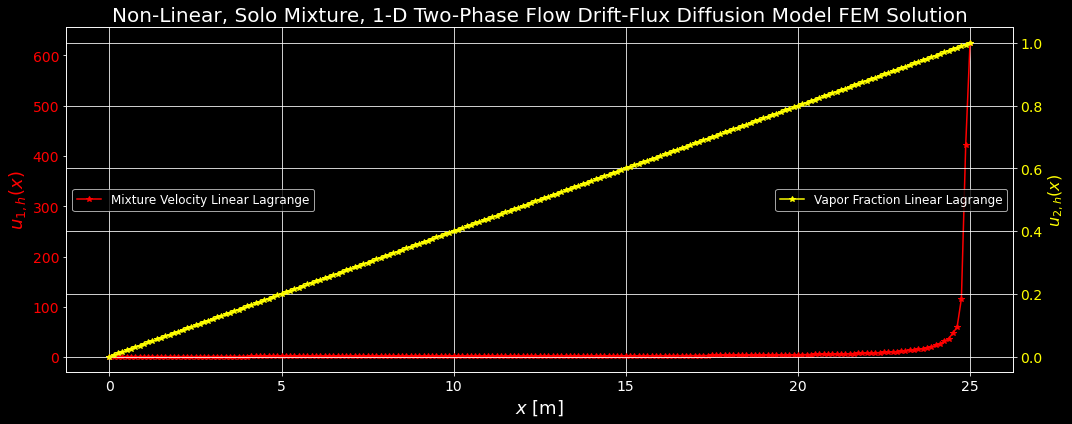

In [52]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Non-Linear, Solo Mixture, 1-D Two-Phase Flow Drift-Flux Diffusion Model FEM Solution', 
              u1_legend=r'Mixture Velocity Linear Lagrange', u2_legend=r'Vapor Fraction Linear Lagrange', save_plot=False)

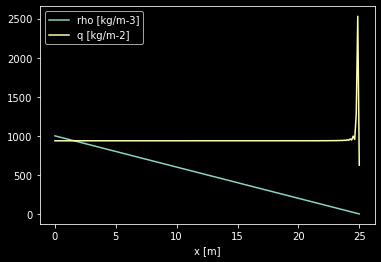

In [53]:
x = df['id']
v = df['mixtureVelocity']
alpha = df['vaporFraction']
rho = rho_v * alpha + (1-alpha)*rho_l
df['x [m]'] = x
df['rho [kg/m-3]'] = rho
df['q [kg/m-2]'] = rho * v
df.plot(kind='line',x='x [m]',y=['rho [kg/m-3]', 'q [kg/m-2]'])
plt.show()

#### [Solo Vapor](#toc)<a id="solovapor"></a>

In [47]:
'''Input file'''
!cat inputSoloVapor.hit

#Engy-5310 Project: Steamer
# UMass Lowell Nuclear Chemical Engineering
# Nikolaus R. Kemper and Jack J. F. Kennedy
# Sat May  1 12:18:50 PM EST 2021


# Parameters
xmin = 0.00000e+00  # [m]
xmax = 2.50000e+01  # [m]
diff_coeff = 2.00000e+00 # [m-2/s]
rho_l = 1000.0000 # [kg/m^3]
rho_v = 1.00000   # [kg/m^3]
mixture_velocity_left = 5 # [m/s]
vapor_fraction_left = 0.1  # []

[Mesh]
 [1d]
   type = GeneratedMeshGenerator
   dim = 1
   xmin = ${replace xmin}
   xmax = ${replace xmax}
   nx = 100
   #elem_type = edge3
 []
[]

[Variables]

 [vaporFraction]
   order = first
   family = lagrange
   #initial_condition = 0.5
   [InitialCondition]
     type = InitialGuess
     bias = 0.5
     coefficient = 0
   []
 []
[]

# Tests
 [AuxVariables]
  [mixtureVelocity]
    order = first
    family = lagrange
    [InitialCondition]
      type = InitialGuess
      #coefficient = ${fparse 9/10}
      coefficient = ${fparse 4/100}
      bias = ${replace mixture_velocity_left}
    []
  []
[]

[Kernels]
 

In [53]:
!./steamer-opt -i inputSoloVapor.hit



Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         
PETSc Version:           3.14.2
SLEPc Version:           3.14.0
Current Time:            Sun May  9 15:52:13 2021
Executable Timestamp:    Sat May  1 13:46:36 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 101
    Local:                 101
  Elems:                   
    Total:                 100
    Local:                 100
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                101
  Num Local DOFs:          101
  Variables:               "vaporFraction" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                101
  Num Local DOFs:          101
  Variables:               "m

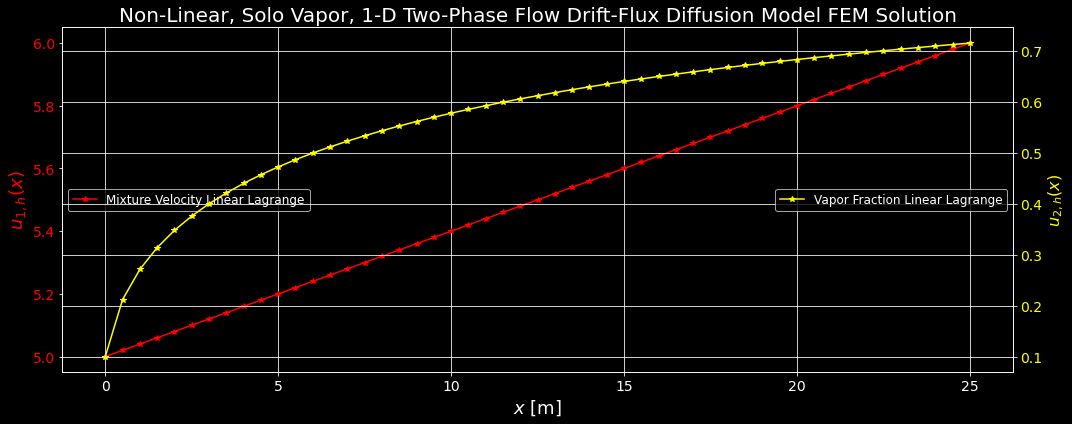

In [54]:
'''Show FEM Solution'''

df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Non-Linear, Solo Vapor, 1-D Two-Phase Flow Drift-Flux Diffusion Model FEM Solution', 
              u1_legend=r'Mixture Velocity Linear Lagrange', u2_legend=r'Vapor Fraction Linear Lagrange', save_plot=False)

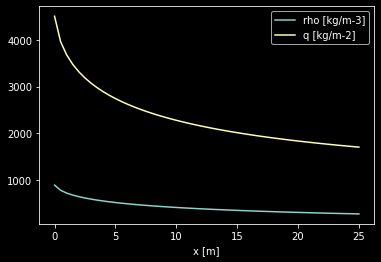

In [51]:
df
x = df['id']
v = df['mixtureVelocity']
alpha = df['vaporFraction']
rho = rho_v * alpha + (1-alpha)*rho_l
df['x [m]'] = x
df['rho [kg/m-3]'] = rho
df['q [kg/m-2]'] = rho * v
df.plot(kind='line',x='x [m]',y=['rho [kg/m-3]', 'q [kg/m-2]'])
plt.show()

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Non-Linear, Coupled, 1-D Two-Phase Flow Drift-Flux Diffusion Model FEM Solution', 
              u1_legend=r'Mixture Velocity Linear Lagrange', u2_legend=r'Vapor Fraction Linear Lagrange', save_plot=False)

## <span style="color:red"><b>**Pending:** plot of $\rho$ and $\rho v$; need to create the fields</b></span>

## [Results and Analysis](#toc)<a id="ranalysis"></a>

Looking at the solution plot, the vapor fraction and mixture velocity are shown to be highly dependent on not just the boundary conditions, but also the coefficient parameters. Specifically, the diff_coeff, artificial_viscosity, and source_s coefficients make a very significant difference upon further inspection. 

By using the input file input.hit, you can see that the vapor fraction quickly rises at the beginning and then tappers out towards the end. Because the ending vapor fraction is not defined by a Dirichlet boundary condition, the final value is not currently equal to 1. It can also be seen that our mixture velocity is nowhere close to where the predicted value. The mixture velocity should approach:
\begin{align*}
\\
V(b) = V_\text{0}\, *  \rho_\text{v}\ / \rho_\text{l}\
\\
\\
\end{align*}
Which in this case should be 936.7 m/s using a no-slip condition; however, currently the model is only at about 3.43 m/s at a final vapor fraction of 72.8% which. The error between our model and the expected no slip conditions increases as Z increases to a final value of 0.025% at Z=b. This error can be reduced more by adding more points.

This program can also be modified to achieve a vapor fraction close to 100%, however due to the nature of this problem, the change in velocity can get quite steep and may introduce more convergence errors.

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] Neil E. Todreas and Mujid S. Kazimi (2011), [Nuclear Systems Volume 1: Thermal Hydraulic Fundamentals (Second Edition)], CRC Press
- [4] L. S. Tong and Joel Weisman (1996), [Thermal Analysis of Pressurized Water Reactors (Third Edition)], ANS, ISBN: 0-89448-038-3